In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *

0. Подобрать набор данных для классификации (количество классов не имеет значения) и регрессии. Важно наличие числовых и категориальных признаков в данных. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. 

In [2]:
heart_disease_df = pd.read_csv("./data/heart_2020_cleaned.csv")
heart_disease_df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [3]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [4]:
y = heart_disease_df['HeartDisease']
X = heart_disease_df.drop('HeartDisease', axis=1)
X

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [23]:
def get_cat_columns_indicies(df):
    df_columns = list(df)
    cat_columns_ind = []
    for i in range(len(df_columns)):
        if df[df_columns[i]].dtype == 'object':
            cat_columns_ind.append(i)
    return cat_columns_ind

def get_cat_and_num_columns(df):
    df_categorical_columns = list(df.select_dtypes(include='object'))
    return df_categorical_columns, [c for c in df.columns if c not in df_categorical_columns]

In [6]:
cat_features = get_cat_columns_indicies(X)
print(cat_features)

[1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]


1. Применить классификатор CatBoostClassifier к вашему набору данных.

In [7]:
from catboost import Pool

pool1 = Pool(data=X, label=y, cat_features=cat_features)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1234)

In [9]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    task_type="GPU",
    eval_metric="AUC"
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    logging_level='Silent',
    use_best_model=True
)

print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 100, 'learning_rate': 0.1, 'eval_metric': 'AUC', 'task_type': 'GPU'}


- Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.

In [10]:
print(model.get_best_iteration())

99


In [11]:
print(model.get_best_score())

{'learn': {'Logloss': 0.2217461914935865}, 'validation': {'Logloss': 0.22689525607731179, 'AUC': 0.8423936069011688}}


- Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо).

In [28]:
def factorize_columns(df, columns_to_factorize):
    for col in columns_to_factorize:
        df[col] = pd.factorize(df[col])[0]
    return df

In [33]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder

class_encoder = LabelEncoder()
class_encoder.fit(y_test)
y_enc = class_encoder.transform(y_test)
pred_enc = class_encoder.transform(model.predict(X_test))
print(f"Accuracy: {accuracy_score(y_test, model.predict(X_test))}")
print(f"AUC: {roc_auc_score(y_enc, pred_enc)}")
print(f"Precision: {precision_score(y_enc, pred_enc)}")
print(f"Recall: {recall_score(y_enc, pred_enc)}")

Accuracy: 0.9154023189783487
AUC: 0.5396161224845946
Precision: 0.5649257307139435
Recall: 0.08544716625597913


- В случае бинарной классификации на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

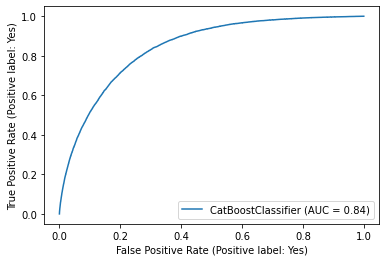

In [14]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, X_test, y_test, name='CatBoostClassifier')

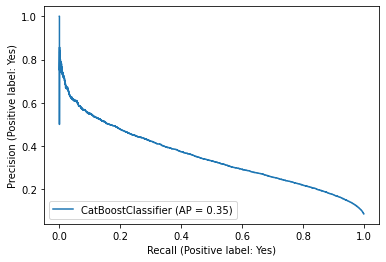

In [15]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name='CatBoostClassifier')

2. Применить регрессию CatBoostRegressor к набору данных для регрессии. Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации. Обратите внимание, что в задаче восстановления регрессии целевая переменная имеет непрерывные значения.

In [35]:
from catboost import CatBoostRegressor

reg = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    task_type="GPU",
    custom_metric=['MAE','RMSE']
)

y = pd.factorize(heart_disease_df['HeartDisease'].copy())[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1234)

reg.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    logging_level='Silent',
    use_best_model=True
)

In [36]:
print(reg.get_best_iteration())
print(reg.get_best_score())

97
{'learn': {'MAE': 0.12916211539694303, 'RMSE': 0.2530785227943231}, 'validation': {'MAE': 0.13124934528574467, 'RMSE': 0.2565325425558836}}


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f"MAE: {mean_absolute_error(y_test, reg.predict(X_test))}")
print(f"MSE: {mean_squared_error(y_test, reg.predict(X_test))}")

MAE: 0.13125104282555566
MSE: 0.06580893863974092
